# Objectives:
1. For each Featurization(BOWs, TF-IDF, W2V, AVGW2V-TFIDF) we need to split the data based on Time Based Slicing and apply and Logistic Regression and find test accurcy.

2. apply GridSearchCV and RandomSearchCV to find optimal lambda.
3. Apply L1 and L2 regularization while using algorithm.
4. Try L1 regularization and keep increasing lambda to check sparsity.
5. check multicolliniarity among features and remove features if necessary.
6. Find feature importance and represent using wordcloud.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [5]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;   

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [8]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [81]:
# import pickle
# pickle_out = open("final_string.pickle","wb")
# pickle.dump(final_string, pickle_out)
# pickle_out.close()

In [10]:
import pickle
pickle_in = open("final_string.pickle","rb")
final_string = pickle.load(pickle_in)

In [10]:
final['CleanedText']=final_string

In [11]:
final = final.sort_values(['Time'], ascending=[True])
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'this witti littl book make son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth about e...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel and funni movi keaton hilar...


In [12]:
positive_50000=final.loc[final['Score'] == "positive"].sample(50000)
negative_50000=final.loc[final['Score'] == "negative"].sample(50000)
pos_neg_1l = pd.concat([positive_50000, negative_50000], axis=0)
labels = pos_neg_1l['Score']

In [13]:
pos_neg_1l = pos_neg_1l.sort_values(['Time'], ascending=[True])
pos_neg_1l.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'can rememb see the show when air televis yea...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'myself alway enjoy this movi it veri funni a...
346102,374408,B00004CI84,A1GB1Q193DNFGR,Bruce Lee Pullen,5,5,positive,970531200,Fabulous Comedic Fanasy Directed by a Master,Beetlejuice is an awe-inspiring wonderfully am...,b'beetlejuic wonder amus comed romp that explo...
417901,451923,B00004CXX9,ANIMV3SPDD8SH,Guy De Federicis,1,12,negative,992217600,CASPER IS THE GHOST WITH THE MOST,Michael Keaton brings no distinguishing charac...,b'michael keaton bring distinguish characteris...


In [113]:
X = pos_neg_1l['CleanedText']
y = pos_neg_1l['Score']

# BOW with Logistic Regression

In [114]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [115]:
# code for Bag Of Words calculation
count_vect = CountVectorizer()
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X_train)
# transform test data
X_test = count_vect.transform(X_test)

In [116]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Find Optimal Hyperparameter lambda(1/C) using GridSearchCV

In [18]:
# GridSearchCV: Exhaustive search over specified parameter values for an estimator.
# param_grid: it is a dict objects which takes parameter for an estimator
# best_estimator_ : estimator or dict
# best_score_: float ==> Mean cross-validated score of the best_estimator
# best_params_ : dict ==> Parameter setting that gave the best results on the hold out data
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Setup the hyperparameter grid
#10**-4, 10**-2, 10**0, 10**2, 10**4
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression()

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, tuned_parameters, cv=3)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameter and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: {'C': 100}
Best score is 0.5005857142857143


In [19]:
# Predicting the Test set results
y_pred = logreg_cv.predict(X_test)

In [20]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy %d%%' % (acc))


****Test accuracy 50%


In [21]:
dict = {"positive" : '1', "negative" : '-1'}
y_train =  y_train.map(dict)
y_test = y_test.map(dict)

# Find Optimal Hyperparameter lambda(1/C) using RandomizedSearchCV

In [20]:
# Randomized search on hyper parameters.
# get_params([deep]) ==> Get parameters for this estimator.
# best_estimator_ : estimator or dict
# best_score_ : float ==> Mean cross-validated score of the best_estimator.
# best_params_ : dict ==> Parameter setting that gave the best results on the hold out data.
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform
# Create logistic regression
logistic = linear_model.LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = {'C':C, 'penalty':penalty}
# Create randomized search 5-fold cross validation and 100 iterations
rand_cv = RandomizedSearchCV(logistic, hyperparameters, random_state=1, n_iter=100, cv=3, verbose=0, n_jobs=-1)
# Fit randomized search
best_model = rand_cv.fit(X_train, y_train)
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best Score:', best_model.best_score_)

Best Penalty: l1
Best C: 0.236972805206
Best Score: 0.5017


In [22]:
# Predicting the Test set results
y_pred = best_model.predict(X_test)

In [23]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred, normalize=True) * float(100)
print('\n****Test accuracy %d%%' % (acc))


****Test accuracy 49%


# With L1 regularization Sparsity decreases with increasing C(inverse of lambda)

In [20]:
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
# ppf(q, loc=0, scale=1) Percent point function (inverse of cdf — percentiles).
x = np.linspace(uniform.ppf(0.01),uniform.ppf(0.99), 100)

for i in x:
    clf_l1_LR = LogisticRegression(C=i, penalty='l1', tol=0.01)
    clf_l1_LR.fit(X_train, y_train)
    coef_l1_LR = clf_l1_LR.coef_.ravel()
    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    print("Sparsity with L1 penalty: %.2f%%" % sparsity_l1_LR)

Sparsity with L1 penalty: 83.76%
Sparsity with L1 penalty: 73.31%
Sparsity with L1 penalty: 67.25%
Sparsity with L1 penalty: 63.46%
Sparsity with L1 penalty: 60.59%
Sparsity with L1 penalty: 60.36%
Sparsity with L1 penalty: 58.83%
Sparsity with L1 penalty: 57.76%
Sparsity with L1 penalty: 56.68%
Sparsity with L1 penalty: 55.74%
Sparsity with L1 penalty: 54.79%
Sparsity with L1 penalty: 53.99%
Sparsity with L1 penalty: 52.98%
Sparsity with L1 penalty: 52.53%
Sparsity with L1 penalty: 47.60%
Sparsity with L1 penalty: 51.74%
Sparsity with L1 penalty: 51.22%
Sparsity with L1 penalty: 50.84%
Sparsity with L1 penalty: 49.75%
Sparsity with L1 penalty: 50.07%
Sparsity with L1 penalty: 49.58%
Sparsity with L1 penalty: 49.19%
Sparsity with L1 penalty: 48.04%
Sparsity with L1 penalty: 48.43%
Sparsity with L1 penalty: 48.20%
Sparsity with L1 penalty: 47.92%
Sparsity with L1 penalty: 45.56%
Sparsity with L1 penalty: 47.22%
Sparsity with L1 penalty: 46.90%
Sparsity with L1 penalty: 46.01%
Sparsity w

# Multicolliniarity Test using VIF

In [21]:
# If my Xi’s are highly correlated then |X’X| will be close to 0 and hence inverse of (X’X) will not exist
# or will be indefinitely large. Mathematically, which will be indefinitely large in presence of multicollinearity.
# Multicollinearity increases the estimate of standard error of regression coefficients which makes some variables
# statistically insignificant when they should be significant.
# VIF (Variance Inflation Factor) Method:
# VIF calculations are straightforward and easily comprehensible: the higher the value, the higher the collinearity.
# A VIF is calculated for each explanatory variable and those with high values are removed. 
# The definition of ‘high’ is somewhat arbitrary but values in the range of 5-10 are commonly used.
# It takes the following formule:
   
#VIF=1/(1−R2)

In [120]:
dict = {"positive" : '1', "negative" : '-1'}
y_train =  y_train.map(dict)
y_test = y_test.map(dict)

In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
clf = LogisticRegression(random_state=0, C = 0.01, solver='saga').fit(X_train, y_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [123]:
# Predicting the Test set results
y_pred = clf.predict(X_test)

In [124]:
from sklearn.metrics import r2_score
VIF = 1/(1 - r2_score(y_test, y_pred))

In [125]:
VIF

2.0519828454172369

# Observation:

VIF = 2.05 which is less than 5 so we can ignore multicollinirity problem.

# Get Important Features and Represent with WordCloud

In [34]:
def find_imp_features_bow(classifier):
    list_negative = []
    list_positive = []
    global impwords_bow
    impwords_bow = []
    feature_names = count_vect.get_feature_names()
    for i,j in sorted(zip(feature_names, classifier.coef_[0]), key=lambda x: x[1]):
        if j < 0:
            list_negative.append(i)
        else:
            list_positive.append(i)
    impwords_bow.append(list_negative[:10] + sorted(list_positive[-10:]))
    return list_negative[:10], sorted(list_positive[-10:])

In [35]:
find_imp_features_bow(clf)

(['not',
  'disappoint',
  'worst',
  'aw',
  'horribl',
  'terribl',
  'threw',
  'unfortun',
  'disgust',
  'return'],
 ['amaz',
  'best',
  'delici',
  'excel',
  'favorit',
  'good',
  'great',
  'love',
  'nice',
  'perfect'])

In [37]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [38]:
important_words_bow = ' '
for words in impwords_bow[0]: 
    important_words_bow = important_words_bow + words + ' '

In [39]:
wordcloud_bow = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(important_words_bow) 

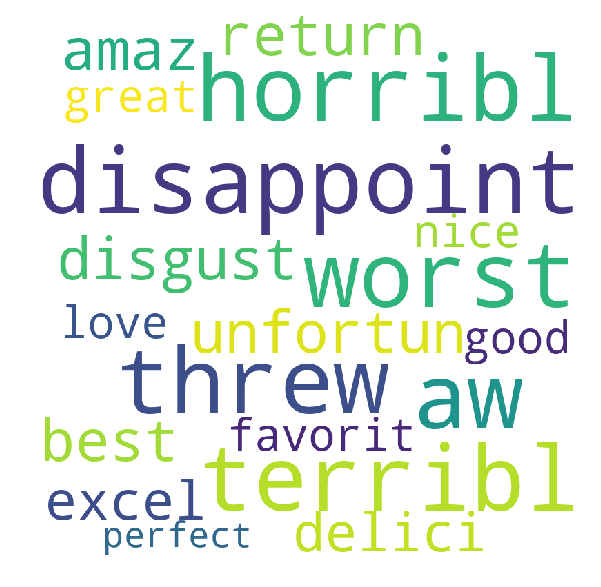

In [41]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_bow) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# TF-IDF with Logistic Regression


In [42]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.3, random_state=0)

In [43]:
dict = {"positive" : '1', "negative" : '-1'}
y_train_tfidf =  y_train_tfidf.map(dict)
y_test_tfidf = y_test_tfidf.map(dict)

In [44]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(X_train_tfidf)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidf)

In [45]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(final_tf_idf_train)
# transform both train and test data
final_tf_idf_train = scaler.transform(final_tf_idf_train)
final_tf_idf_test = scaler.transform(final_tf_idf_test)

In [47]:
clf = LogisticRegression(random_state=0, C = 0.01, solver='saga').fit(final_tf_idf_train, y_train_tfidf)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [48]:
# Predicting the Test set results
y_pred = clf.predict(final_tf_idf_test)

In [49]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidf, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 89%


In [50]:
from sklearn.metrics import r2_score
VIF = 1/(1 - r2_score(y_test_tfidf, y_pred))

In [51]:
VIF

2.4303296500324043

In [52]:
def find_imp_features_tfidf(classifier):
    list_negative = []
    list_positive = []
    global impwords_tfidf
    impwords_tfidf = []
    feature_names = tf_idf_vect.get_feature_names()
    for i,j in sorted(zip(feature_names, classifier.coef_[0]), key=lambda x: x[1]):
        if j < 0:
            list_negative.append(i)
        else:
            list_positive.append(i)
    impwords_tfidf.append(list_negative[:10] + sorted(list_positive[-10:]))
    return list_negative[:10], sorted(list_positive[-10:])

In [53]:
find_imp_features_tfidf(clf)

(['not',
  'disappoint',
  'was',
  'veri disappoint',
  'wast',
  'money',
  'not buy',
  'would not',
  'return',
  'bad'],
 ['best',
  'delici',
  'favorit',
  'good',
  'great',
  'high recommend',
  'love',
  'love this',
  'perfect',
  'the best'])

In [54]:
important_words_tfidf = ' '
for words in impwords_tfidf[0]: 
    important_words_tfidf = important_words_tfidf + words + ' '

In [55]:
wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(important_words_tfidf) 

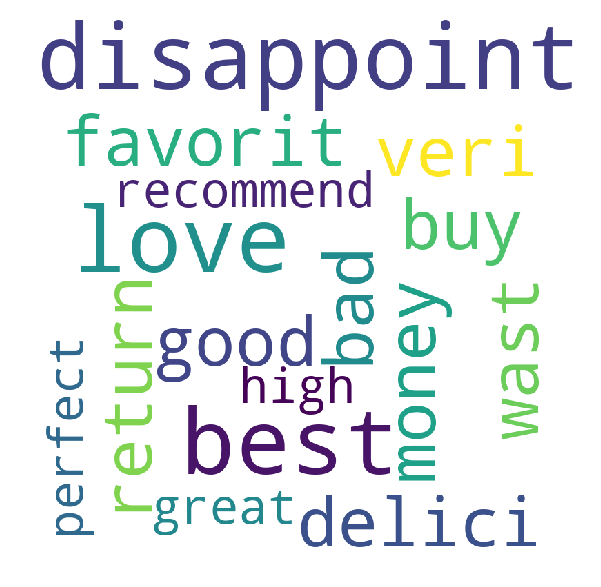

In [57]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# AvgW2V with Logistic Regression

In [58]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [60]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [61]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [62]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [63]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [64]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(sent_vectors_test)
df_test = df_test.fillna(df_test.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_train_avgw2v = scaler.transform(df_train)
standardized_data_test_avgw2v = scaler.transform(df_test)

In [65]:
dict = {"positive" : '1', "negative" : '-1'}
y_train_avgw2v =  y_train_avgw2v.map(dict)
y_test_avgw2v = y_test_avgw2v.map(dict)

In [66]:
clf = LogisticRegression(random_state=0, C = 0.01, solver='saga').fit(standardized_data_train_avgw2v, y_train_avgw2v)

In [67]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_test_avgw2v)

In [68]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_avgw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 83%


In [69]:
from sklearn.metrics import r2_score
VIF = 1/(1 - r2_score(y_test_avgw2v, y_pred))

In [70]:
VIF

1.4895724528301888

In [71]:
def find_imp_features_w2v(classifier):
    stop_words = set(stopwords) 
    list_negative = []
    list_positive = []
    global impwords_w2v
    impwords_w2v = []
    for i,j in sorted(zip(w2v_model.wv.vocab.keys(), clf.coef_[0]), key=lambda x: x[1]):
        if i not in stop_words:
            if j < 0:
                list_negative.append(i)
            else:
                list_positive.append(i)
    impwords_w2v.append(list_negative[:10] + sorted(list_positive[-10:]))
    return list_negative[:10], sorted(list_positive[-10:])

In [72]:
find_imp_features_w2v(clf)

(['faux',
  'unfortun',
  'brand',
  'result',
  'delici',
  'enfamil',
  'coupl',
  'substitut',
  'cherri',
  'spit'],
 ['befor',
  'better',
  'consider',
  'half',
  'ill',
  'lot',
  'lower',
  'now',
  'provid',
  'tast'])

In [73]:
important_words_w2v = ' '
for words in impwords_w2v[0]: 
    important_words_w2v = important_words_w2v + words + ' '

In [74]:
wordcloud_w2v = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(important_words_w2v) 

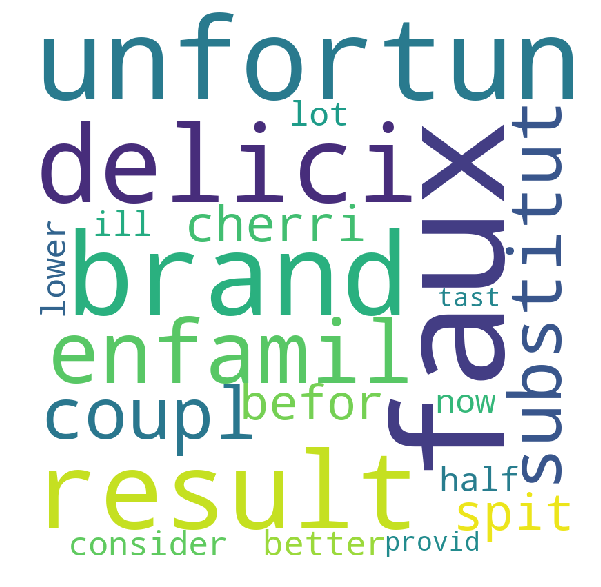

In [75]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_w2v) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# TFIDF-W2V with Logistic Regression

# calculating W2V for 40K

In [78]:
positive_20000=final.loc[final['Score'] == "positive"].tail(20000)
negative_20000=final.loc[final['Score'] == "negative"].tail(20000)
pos_neg_40k = pd.concat([positive_20000, negative_20000], axis=0)
labels = pos_neg_40k['Score']

In [79]:
pos_neg_40k = pos_neg_40k.sort_values(['Time'], ascending=[True])
pos_neg_40k.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
261899,283904,B00455GM9E,A1FBLR62DJ46L3,MaryAnne,0,1,negative,1327968000,Too Sweet,It is ok as long as you only use half as much ...,b'long you onli use half much syrup call for a...
454702,491596,B001M1Z1EQ,A6KCWLEG41R4J,Ms Sensitive,0,0,negative,1327968000,Unpleasant product,The bread pudding I received was in different ...,b'the bread pud receiv was differ packag than ...
205284,222415,B004E4CCSQ,A2SZLNSI5KOQJT,"Carrie, ""Formerly &#34;Sister Carrie&#34;""",0,1,negative,1327968000,OK Taste. Fuzzy-Peachy Flavor. But Also a Ch...,The MIO Peach Tea flavor is definitely a fuzzy...,b'the mio peach tea flavor definit fuzzi peach...
326016,352840,B001SAY7BO,A6L0WHWTB31OC,"A. M. Smith ""morg999""",2,2,negative,1327968000,Amazingly BAD....,I would like to start by saying that I have ne...,b'would like start say that have never written...
86027,93669,B004IJMVQA,A4OD6YMH5FLV5,S. Montane,1,1,negative,1327968000,Yuck.,"I love Peanut Butter Puffins, but this is not ...",b'love peanut butter puffin but this not nor d...


In [140]:
X = pos_neg_40k['CleanedText']
y = pos_neg_40k['Score']

In [141]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_avgw2v, X_test_avgw2v, y_train_avgw2v, y_test_avgw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [142]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X_train_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [143]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [144]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent_test=[]
for sent in X_test_avgw2v.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [145]:
from sklearn.model_selection import train_test_split
# Split arrays or matrices into random train and test subsets
# test_size=0.3 means out of 10k 3k will be test set and 7k train set
X_train_tfidfw2v, X_test_tfidfw2v, y_train_tfidfw2v, y_test_tfidfw2v = train_test_split(X, y, test_size=0.3, random_state=0)

In [146]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train_tfidfw2v)
final_tf_idf_test = tf_idf_vect.transform(X_test_tfidfw2v)

##### calculate TF-IDF weighted Word2Vec for train data

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [147]:
import pickle
pickle_in = open("train_w2vtfidf.pickle","rb")
tfidf_sent_vectors = pickle.load(pickle_in)

##### calculate TF-IDF weighted Word2Vec for test data

In [128]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
                                     #obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [129]:
# pickle_out = open("test_w2vtfidf1.pickle","wb")
# pickle.dump(tfidf_sent_vectors_test, pickle_out)
# pickle_out.close()

In [148]:
pickle_in = open("test_w2vtfidf1.pickle","rb")
tfidf_sent_vectors_test = pickle.load(pickle_in)

##### Do standadization for train and test vectors

In [149]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())
df_test = pd.DataFrame(tfidf_sent_vectors_test)
df_test = df_test.fillna(df_test.mean())
from sklearn.preprocessing import StandardScaler
standardized_data_tf_idfw2v_train = StandardScaler(with_mean=False).fit_transform(df_train)
standardized_data_tf_idfw2v_test = StandardScaler(with_mean=False).fit_transform(df_test)

In [150]:
dict = {"positive" : '1', "negative" : '-1'}
y_train_tfidfw2v =  y_train_tfidfw2v.map(dict)
y_test_tfidfw2v = y_test_tfidfw2v.map(dict)

In [151]:
clf = LogisticRegression(random_state=0, C = 0.01, solver='saga').fit(standardized_data_tf_idfw2v_train, y_train_tfidfw2v)

In [152]:
# Predicting the Test set results
y_pred = clf.predict(standardized_data_tf_idfw2v_test)

In [153]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_tfidfw2v, y_pred, normalize=True) * float(100)
print('\n****Test accuracy is %d%%' % (acc))


****Test accuracy is 59%


In [154]:
from sklearn.metrics import r2_score
VIF = 1/(1 - r2_score(y_test_tfidfw2v, y_pred))

In [155]:
VIF

0.61199075207398324

In [156]:
def find_imp_features_tfidf_avgw2v(classifier):
    stop_words = set(stopwords) 
    list_negative = []
    list_positive = []
    global impwords_tfidf_avgw2v
    impwords_tfidf_avgw2v = []
    feature_names = w2v_model.wv.vocab.keys()
    for i,j in sorted(zip(feature_names, classifier.coef_[0]), key=lambda x: x[1]):
        if i not in stop_words:
            if j < 0:
                list_negative.append(i)
            else:
                list_positive.append(i)
    impwords_tfidf_avgw2v.append(list_negative[:10] + sorted(list_positive[-10:]))
    return list_negative[:10], sorted(list_positive[-10:])

In [157]:
find_imp_features_tfidf_avgw2v(clf)

(['nice',
  'coat',
  'favorit',
  'deform',
  'mix',
  'drawer',
  'found',
  'open',
  'one',
  'seem'],
 ['candi',
  'correct',
  'doesnt',
  'doorstep',
  'good',
  'melt',
  'much',
  'pound',
  'storag',
  'sturdi'])

In [158]:
important_words_tfidf_w2v = ' '
for words in impwords_tfidf_avgw2v[0]: 
    important_words_tfidf_w2v = important_words_tfidf_w2v + words + ' '

In [159]:
wordcloud_tfidf_w2v = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(important_words_tfidf_w2v) 

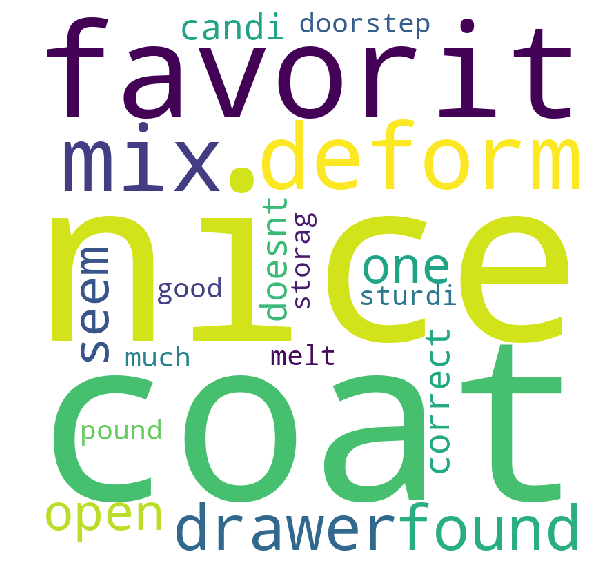

In [160]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_tfidf_w2v) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# Conclusion:

In [161]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "hyper parameter- C", "train error", "test error"]
x.add_row(["LR-BOW", .01, "", "50%"])
x.add_row(["LR-TFIDF", .01, "", "11%"])
x.add_row(["LR-AVGW2V", .01, "", "13%"])
x.add_row(["LR-TFIDFAVGW2V", .01, "", "41%"])
print("Featurization With Logistic Regression:")
print(x)

Featurization With Logistic Regression:
+----------------+--------------------+-------------+------------+
|     Model      | hyper parameter- C | train error | test error |
+----------------+--------------------+-------------+------------+
|     LR-BOW     |        0.01        |             |    50%     |
|    LR-TFIDF    |        0.01        |             |    11%     |
|   LR-AVGW2V    |        0.01        |             |    13%     |
| LR-TFIDFAVGW2V |        0.01        |             |    41%     |
+----------------+--------------------+-------------+------------+
